In [2]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
sns.set_style('white', {'axes.grid' : False})
def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
vector(False)

In [3]:
sample = 'dcis1'

In [4]:
rna = sc.read_h5ad(f'../../RNA_cluster/{sample}.rna.h5ad')

In [5]:
rna = sc.read_h5ad(f'../../RNA_cluster/{sample}.rna.h5ad')
snv = sc.read_h5ad(f'../../SNV_process/norm/{sample}.norm_snv.h5ad')
snv.obs['cluster'] = rna.obs['cluster']

In [6]:
snv.X = snv.layers['norm']

# Subclone

In [6]:
rna = sc.read_h5ad('./DCIS_A.raw_rna.h5ad')
adata = rna[rna.obs['RNA_cluster'] == 'Tumor'].copy()
sc.pp.filter_genes(adata, min_cells = 10)

In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

/home/liuyi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


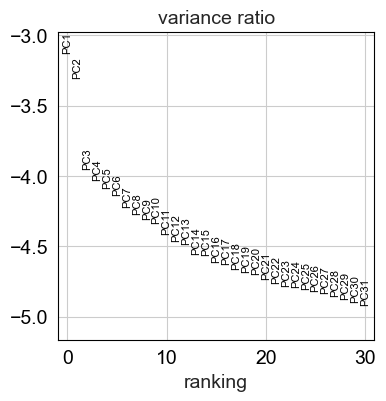

In [12]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata,n_pcs=30, log=True)

In [13]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=15)
sc.tl.umap(adata)

/home/liuyi/miniconda3/envs/scanpy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
sc.tl.leiden(adata,resolution=0.1)

In [15]:
match = {'0':'subclone 0','1':'subclone 1','2':'subclone 2'}
adata.uns['RNA_cluster_colors'] = ['#aecde2','#f4c27b','#a65f35']
adata.obs['RNA_cluster'] = adata.obs['leiden'].apply(lambda x : match[x])

/home/liuyi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/liuyi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/liuyi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/liuyi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 

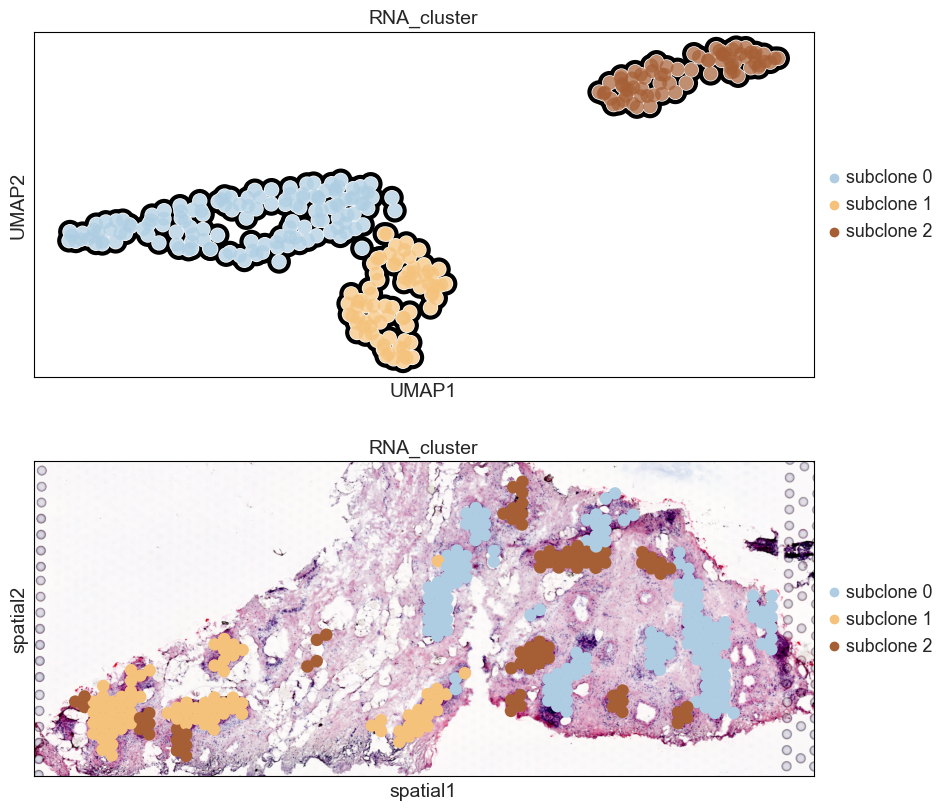

In [16]:
fig, axs = plt.subplots(2,1,figsize=(10,10))
sc.pl.umap(adata, color=['RNA_cluster'],show=False,ax= axs[0],add_outline=True)
sc.pl.spatial(adata,basis = 'spatial',color = 'RNA_cluster',spot_size = 70,show=False,ax= axs[1])
plt.savefig(f'./MainFigure//Fig3B.RNA_subclone.pdf', bbox_inches='tight')

In [17]:
adata.write('dcis1.subclone.h5ad')

# FigD

In [8]:
rawrna = sc.read_h5ad('./DCIS_A.raw_rna.h5ad')
rawrna = rawrna[rawrna.obs_names.isin(rna.obs_names)].copy()
sc.pp.normalize_total(rawrna, target_sum=1e4)
sc.pp.log1p(rawrna)

In [9]:
adata = sc.read_h5ad('dcis1.cluster.h5ad')
snv.obs['RNA_cluster'] = adata.obs['RNA_cluster']

In [7]:
tumorsnv = snv[~snv.obs['RNA_cluster'].isna()].copy()

In [8]:
import numpy as np
from scipy.stats import zscore
from scipy.cluster.hierarchy import linkage, dendrogram,fcluster

def adata_group(adata, groupby, layer=None, use_raw=False, min_cells=0):
    counts = adata.obs[groupby].value_counts() 
    indiv = counts[counts >= min_cells].index
    adata = adata[adata.obs[groupby].isin(indiv), :]
    index = adata.obs[groupby].unique()
    if use_raw:
        adata = adata.raw.to_adata()
    if layer is not None:
        csr = adata.layers[layer]
    else:
        csr = adata.X
    df = pd.DataFrame([np.array(csr[adata.obs[groupby]==x, :].sum(axis=0))[0, :] for x in index], index=index, columns=adata.var_names)
    bulk = sc.AnnData(df)
    bulk.obs[groupby] = bulk.obs_names.values
    return bulk

In [9]:
sc.pp.filter_genes(tumorsnv,min_cells = 1)

In [10]:
tumorsnv.uns['log1p']['base'] = None
sc.tl.rank_genes_groups(tumorsnv, 'RNA_cluster', method='wilcoxon')

In [11]:
result = tumorsnv.uns['rank_genes_groups']
groups = result['names'].dtype.names
lfc = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']})

In [12]:
dif_snv_list = []
for n in range(3):
    sub_lfc = lfc[[f'subclone {n}_n',f'subclone {n}_p',f'subclone {n}_l']]
    sub_lfc = sub_lfc[(sub_lfc[f'subclone {n}_p'] <0.05)&(sub_lfc[f'subclone {n}_l'] >= 1)]
    sub_lfc = sub_lfc[f'subclone {n}_n'].to_frame()
    sub_lfc.columns = ['snv']
    sub_lfc['type'] = f"subclone {n}"
    dif_snv_list.append(sub_lfc)
dif_snv = pd.concat(dif_snv_list)
tumorsnv = tumorsnv[:,tumorsnv.var_names.isin(dif_snv['snv'])]

In [13]:
dif_snv['snv'] = dif_snv['snv'].map(lambda x: x.replace('_','-'))
dif_snv.to_csv('./subclone.dif.gene',index=None)

In [14]:
group_snv = adata_group(tumorsnv,groupby = 'RNA_cluster')

In [15]:
snv_matrix = group_snv.X
snv_variances = np.sqrt(np.var(snv_matrix, axis=0))
snv_cv = snv_variances/np.mean(snv_matrix,axis = 0)
threshold = 0
snv_selected_columns = np.where(snv_cv > threshold)[0]
sub_snv = group_snv[:,snv_selected_columns].copy()
sub_snv.X = zscore(sub_snv.X,axis = 0)

In [16]:
data = pd.DataFrame(sub_snv.X,index = sub_snv.obs_names,columns=sub_snv.var_names).T.dropna()

In [17]:
data_for_plot = data.loc[:, ['subclone 0', 'subclone 1', 'subclone 2']]

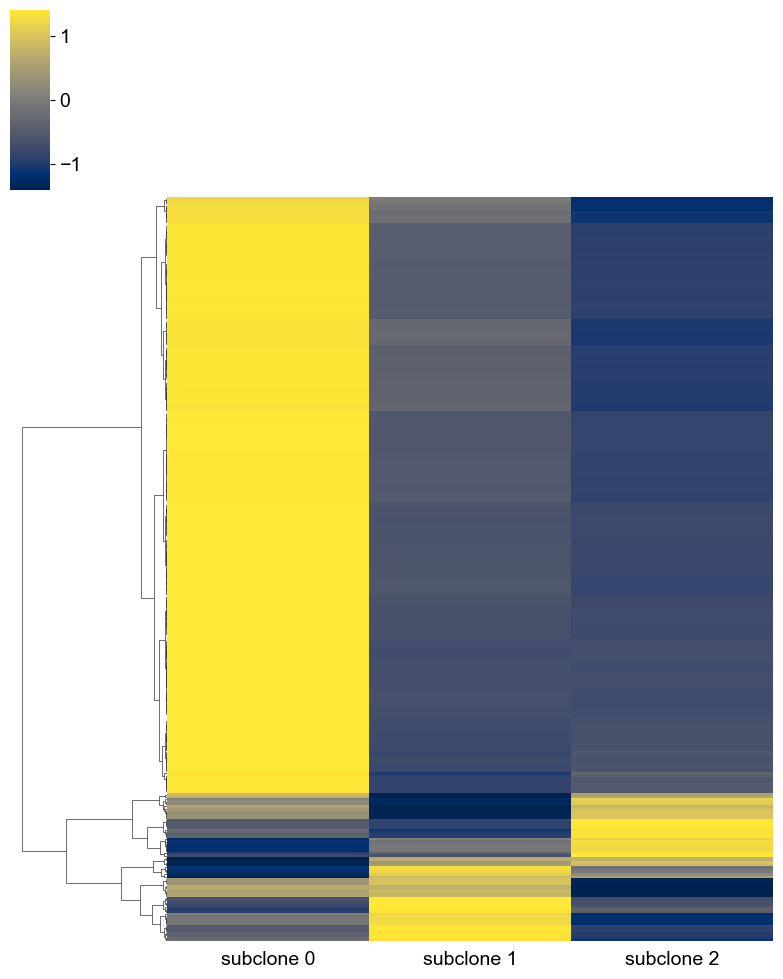

In [18]:
clustermap = sns.clustermap(
    data_for_plot,
    figsize=(8,10),
    row_cluster=True,
    col_cluster=False,
    cmap='cividis',
    method="ward",
    yticklabels=False
)
clustermap.savefig('./MainFigure/hm.pdf')

In [19]:
from scipy.interpolate import CubicSpline
from scipy.interpolate import UnivariateSpline

In [20]:
monocle = pd.read_csv('./cell_trajectory_data.csv',index_col = 0)
monocle.index.name =None
monocle['cluster'] = adata.obs['RNA_cluster']

In [257]:
sc.tl.rank_genes_groups(tumorsnv, 'RNA_cluster',groups=["subclone 0"], reference="subclone 2", method='wilcoxon')

In [258]:
sc.get.rank_genes_groups_df(tumorsnv, group = 'subclone 0')[:5]

,names,scores,logfoldchanges,pvals,pvals_adj
0,chr7_45183887:G>T,6.107123,1.616533,1.014432e-09,3.215751e-07
1,chr7_45183945:G>A,5.814566,1.460720,6.079142e-09,6.423627e-07
2,chr11_86809174:T>C,5.652441,4.365886,1.581854e-08,1.253619e-06
3,chr11_62242319:G>T,5.378169,1.214060,7.524727e-08,4.770677e-06
4,chr15_43115657:A>G,5.080736,1.484992,3.759753e-07,1.986403e-05


In [260]:
monocle = pd.read_csv('./cell_trajectory_data.csv',index_col = 0)
monocle.index.name =None
monocle['cluster'] = adata.obs['RNA_cluster']

In [271]:
sc.tl.rank_genes_groups(tumorsnv, 'RNA_cluster',groups=["subclone 1"], reference="subclone 2", method='wilcoxon')

In [273]:
sc.get.rank_genes_groups_df(tumorsnv, group = 'subclone 1')[:5]

,names,scores,logfoldchanges,pvals,pvals_adj
0,chr11_86808877:T>C,6.595254,2.126110,4.245286e-11,1.345756e-08
1,chr5_173573333:C>T,4.974967,1.890937,6.525888e-07,9.796801e-05
2,chr5_173573379:A>G,4.514744,1.557201,6.339324e-06,5.023914e-04
3,chr2_224225606:T>C,3.790179,3.751638,1.505387e-04,5.302308e-03
4,chr2_224225556:G>A,3.790179,3.711953,1.505387e-04,5.302308e-03


In [300]:
tumorsnv.uns['RNA_cluster_colors'] = ['#B0C5D6','#DEBA82','#935F3B']

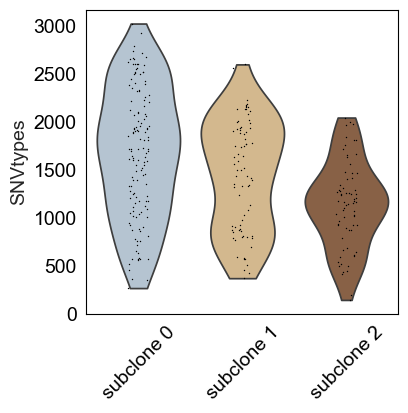

In [305]:
fig,ax = plt.subplots(figsize = (4,4))
sc.pl.violin(tumorsnv,keys = ['SNVtypes'],groupby = 'RNA_cluster',ax = ax,show=False,rotation=45)
ax.grid(False)
fig.savefig('./MainFigure/snvtype.cluster.pdf')

In [186]:
stat_df = []
for snv_name in tumorsnv.var_names:
    tumorsnv.obs['tmp'] = np.sum(tumorsnv[:,snv_name].X,axis = 1)
    submonocle = monocle[monocle['cluster'].isin(['subclone 0','subclone 2'])].copy()
    submonocle['cluster'] = submonocle['cluster'].astype(str)
    submonocle['tmp'] = tumorsnv.obs['tmp']
    r,p = spearmanr(submonocle['Pseudotime'],submonocle['tmp'])
    stat_df.append([snv_name,r,p])
stat_df = pd.DataFrame(stat_df,columns = ['snv','r','p'])
stat_df.sort_values('r',ascending=False)

,snv,r,p
77,chr7_45183887:G>T,0.503731,8.785345e-15
144,chr7_98385752:A>G,0.488091,7.537914e-14
78,chr7_45183945:G>A,0.479776,2.262098e-13
94,chr15_43115657:A>G,0.466886,1.173213e-12
28,chr3_37016583:A>G,0.461113,2.398518e-12
...,...,...,...
40,chr1_27326407:T>C,-0.354385,1.507422e-07
157,chr10_37347026:C>A,-0.357398,1.161287e-07
218,chr21_26235053:T>C,-0.368041,4.521938e-08
46,chrM_1666:T>C,-0.381856,1.261799e-08


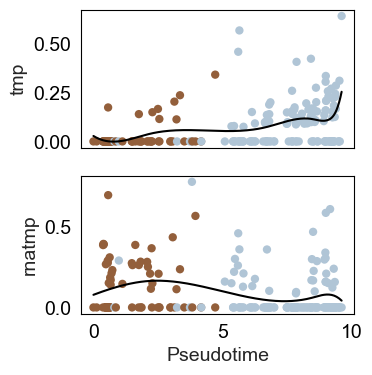

In [418]:
snv_name = "chr7_98385752:A>G"
tumorsnv.obs['tmp'] = np.sum(tumorsnv[:,snv_name].X,axis = 1)
rawrna.obs['rnatmp'] = np.sum(rawrna[:,'BAIAP2L1'].X,axis = 1)
submonocle = monocle[monocle['cluster'].isin(['subclone 0','subclone 2'])].copy()
submonocle['cluster'] = submonocle['cluster'].astype(str)
submonocle['tmp'] = tumorsnv.obs['tmp']
submonocle['rnatmp'] = rawrna.obs['rnatmp']
submonocle = submonocle.sort_values('Pseudotime',ascending=True)
xs = np.linspace(submonocle['Pseudotime'].min(), submonocle['Pseudotime'].max(), 200)
spl = UnivariateSpline(submonocle['Pseudotime'], submonocle['tmp'])
spl.set_smoothing_factor(2)
smooth = spl(xs)


fig,axs = plt.subplots(2,1,figsize = (3.5,4),sharex=True)
sns.lineplot(x=xs, y=smooth, color='black',ax = axs[0])
sns.scatterplot(data = submonocle,x = 'Pseudotime',y = 'tmp',hue = 'cluster',palette={'subclone 0':'#B0C5D6','subclone 1':'#DEBA82','subclone 2':'#935F3B'},edgecolor = 'None',legend=False,ax = axs[0])
axs[0].grid(False)

xs = np.linspace(submonocle['Pseudotime'].min(), submonocle['Pseudotime'].max(), 200)
spl = UnivariateSpline(submonocle['Pseudotime'], submonocle['rnatmp'])
spl.set_smoothing_factor(4.3)
smooth = spl(xs)
sns.lineplot(x=xs, y=smooth, color='black',ax = axs[1])
sns.scatterplot(data = submonocle,x = 'Pseudotime',y = 'rnatmp',hue = 'cluster',palette={'subclone 0':'#B0C5D6','subclone 1':'#DEBA82','subclone 2':'#935F3B'},edgecolor = 'None',legend=False,ax =  axs[1])
axs[1].grid(False)
fig.savefig(f'./MainFigure/{snv_name}.psudo.pdf')

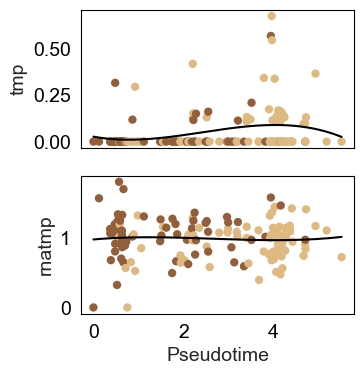

In [417]:
snv_name = "chr19_2813592:G>A"
tumorsnv.obs['tmp'] = np.sum(tumorsnv[:,snv_name].X,axis = 1)
rawrna.obs['rnatmp'] = np.sum(rawrna[:,'THOP1'].X,axis = 1)
submonocle = monocle[monocle['cluster'].isin(['subclone 1','subclone 2'])].copy()
submonocle['cluster'] = submonocle['cluster'].astype(str)
submonocle['tmp'] = tumorsnv.obs['tmp']
submonocle['rnatmp'] = rawrna.obs['rnatmp']
submonocle = submonocle.sort_values('Pseudotime',ascending=True)
xs = np.linspace(submonocle['Pseudotime'].min(), submonocle['Pseudotime'].max(), 200)
spl = UnivariateSpline(submonocle['Pseudotime'], submonocle['tmp'])
spl.set_smoothing_factor(1.8)
smooth = spl(xs)


fig,axs = plt.subplots(2,1,figsize = (3.5,4),sharex=True)
sns.lineplot(x=xs, y=smooth, color='black',ax = axs[0])
sns.scatterplot(data = submonocle,x = 'Pseudotime',y = 'tmp',hue = 'cluster',palette={'subclone 0':'#B0C5D6','subclone 1':'#DEBA82','subclone 2':'#935F3B'},edgecolor = 'None',legend=False,ax = axs[0])
axs[0].grid(False)

xs = np.linspace(submonocle['Pseudotime'].min(), submonocle['Pseudotime'].max(), 200)
spl = UnivariateSpline(submonocle['Pseudotime'], submonocle['rnatmp'])
spl.set_smoothing_factor(20)
smooth = spl(xs)
sns.lineplot(x=xs, y=smooth, color='black',ax = axs[1])
sns.scatterplot(data = submonocle,x = 'Pseudotime',y = 'rnatmp',hue = 'cluster',palette={'subclone 0':'#B0C5D6','subclone 1':'#DEBA82','subclone 2':'#935F3B'},edgecolor = 'None',legend=False,ax =  axs[1])
axs[1].grid(False)

fig.savefig(f'./MainFigure/{snv_name}.psudo.pdf')

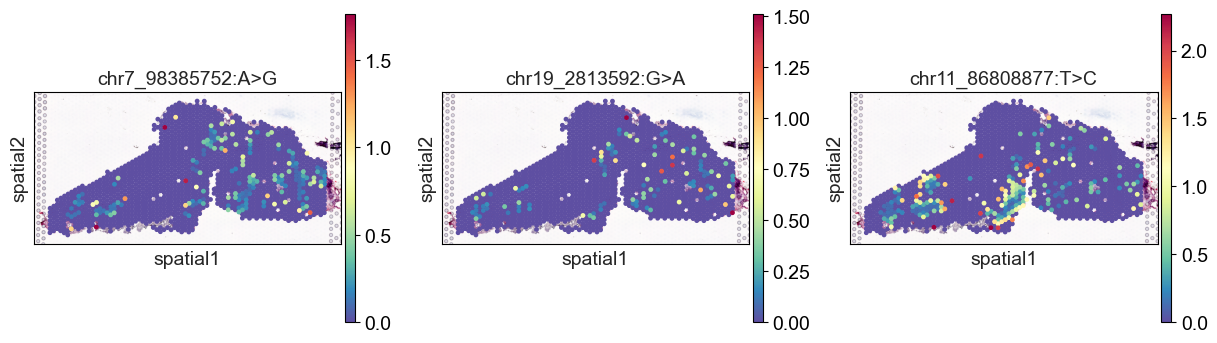

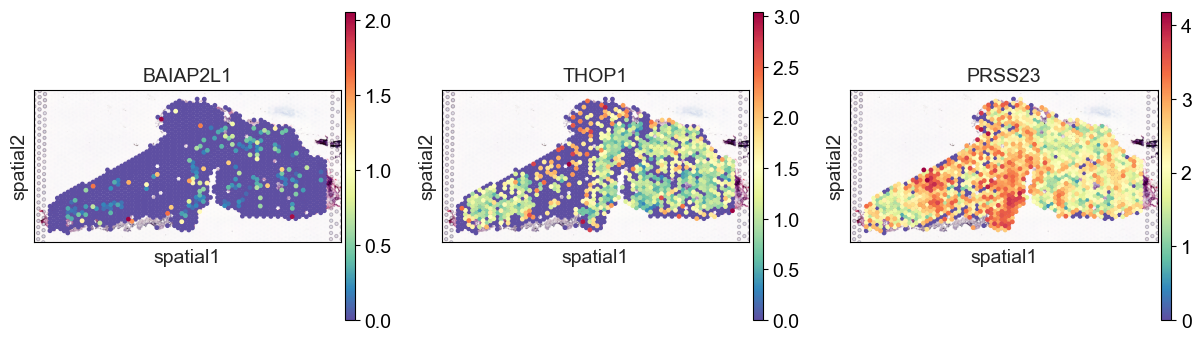

In [397]:
sc.pl.spatial(snv,color = ["chr7_98385752:A>G","chr19_2813592:G>A","chr11_86808877:T>C"],spot_size = 70,vmax = 'p99.9',cmap = 'Spectral_r',save='snv.dis.pdf')
sc.pl.spatial(rawrna,color = ['BAIAP2L1',"THOP1","PRSS23"],spot_size = 70,vmax = 'p99.9',cmap = 'Spectral_r',save='rna.dis.pdf')

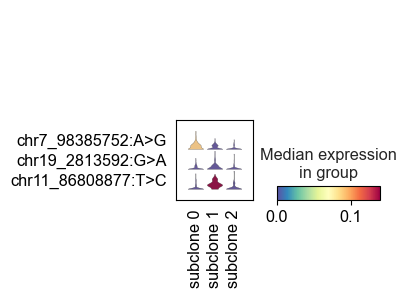

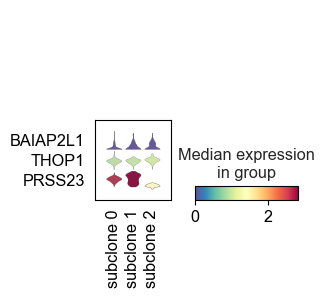

In [398]:
rawrna.obs['sub'] = snv.obs['RNA_cluster']
sc.pl.stacked_violin(snv, ["chr7_98385752:A>G","chr19_2813592:G>A","chr11_86808877:T>C"] , groupby="RNA_cluster", swap_axes=True, dendrogram=False,legend=False,cmap = 'Spectral_r',save='snv.vio.pdf')
sc.pl.stacked_violin(rawrna, ['BAIAP2L1',"THOP1","PRSS23"] , groupby="sub", swap_axes=True, dendrogram=False,legend=False,cmap = 'Spectral_r',save='rna.vio.pdf')

In [ ]:
stat_df = []
for snv_name in tumorsnv.var_names:
    tumorsnv.obs['tmp'] = np.sum(tumorsnv[:,snv_name].X,axis = 1)
    submonocle = monocle[monocle['cluster'].isin(['subclone 1','subclone 2'])].copy()
    submonocle['cluster'] = submonocle['cluster'].astype(str)
    submonocle['tmp'] = tumorsnv.obs['tmp']
    r,p = spearmanr(submonocle['Pseudotime'],submonocle['tmp'])
    stat_df.append([snv_name,r,p])
stat_df = pd.DataFrame(stat_df,columns = ['snv','r','p'])
stat_df.sort_values('r',ascending=False)[20:40]

/tmp/ipykernel_3033551/888318686.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r,p = spearmanr(submonocle['Pseudotime'],submonocle['tmp'])
/tmp/ipykernel_3033551/888318686.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r,p = spearmanr(submonocle['Pseudotime'],submonocle['tmp'])


,snv,r,p
90,chr12_31791306:A>G,0.326338,0.000049
299,chr11_83976913:T>A,0.323182,0.000058
105,chr19_2813592:G>A,0.322869,0.000059
122,chr3_156543007:C>T,0.321656,0.000063
240,chr7_65486446:T>A,0.303424,0.000169
242,chr11_83976836:C>T,0.301844,0.000183
243,chr11_83976876:A>C,0.301844,0.000183
49,chr5_78002523:T>C,0.298206,0.000221
296,chr3_48444201:T>C,0.296948,0.000236
189,chr1_100213846:T>C,0.296908,0.000236


In [343]:
tumorsnv[:,'chr19_2813592:G>A'].var

,gene_ids,feature_types,SNVDepth,SNVCount,n_cells,Func,ExonicFunc,gene_name,gene_lenth,Func_L0
chr19_2813592:G>A,chr19_2813592:G>A,Gene Expression,108.0,108.0,71,UTR3,.,THOP1,30304,UTR


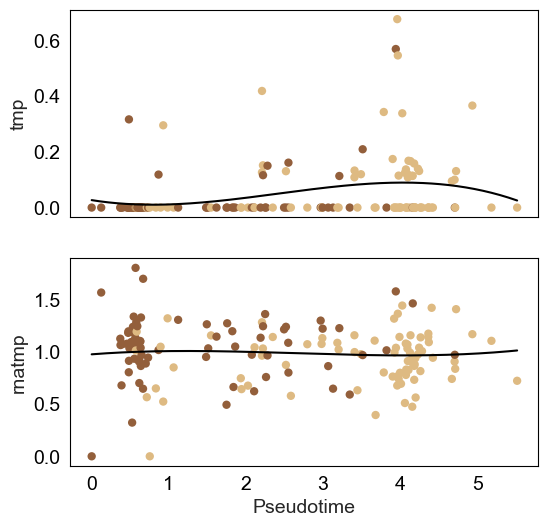

In [344]:
snv_name = "chr19_2813592:G>A"
tumorsnv.obs['tmp'] = np.sum(tumorsnv[:,snv_name].X,axis = 1)
rawrna.obs['rnatmp'] = np.sum(rawrna[:,'THOP1'].X,axis = 1)
submonocle = monocle[monocle['cluster'].isin(['subclone 1','subclone 2'])].copy()
submonocle['cluster'] = submonocle['cluster'].astype(str)
submonocle['tmp'] = tumorsnv.obs['tmp']
submonocle['rnatmp'] = rawrna.obs['rnatmp']
submonocle = submonocle.sort_values('Pseudotime',ascending=True)
xs = np.linspace(submonocle['Pseudotime'].min(), submonocle['Pseudotime'].max(), 200)
spl = UnivariateSpline(submonocle['Pseudotime'], submonocle['tmp'])
spl.set_smoothing_factor(50)
smooth = spl(xs)


fig,axs = plt.subplots(2,1,figsize = (6,6),sharex=True)
sns.lineplot(x=xs, y=smooth, color='black',ax = axs[0])
sns.scatterplot(data = submonocle,x = 'Pseudotime',y = 'tmp',hue = 'cluster',palette={'subclone 0':'#B0C5D6','subclone 1':'#DEBA82','subclone 2':'#935F3B'},edgecolor = 'None',legend=False,ax = axs[0])
axs[0].grid(False)

xs = np.linspace(submonocle['Pseudotime'].min(), submonocle['Pseudotime'].max(), 200)
spl = UnivariateSpline(submonocle['Pseudotime'], submonocle['rnatmp'])
spl.set_smoothing_factor(100)
smooth = spl(xs)
sns.lineplot(x=xs, y=smooth, color='black',ax = axs[1])
sns.scatterplot(data = submonocle,x = 'Pseudotime',y = 'rnatmp',hue = 'cluster',palette={'subclone 0':'#B0C5D6','subclone 1':'#DEBA82','subclone 2':'#935F3B'},edgecolor = 'None',legend=False,ax =  axs[1])
axs[1].grid(False)

# fig.savefig(f'./MainFigure/{snv_name}.psudo.pdf')

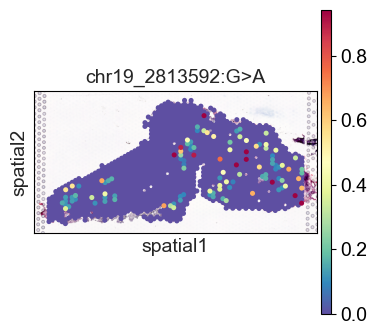

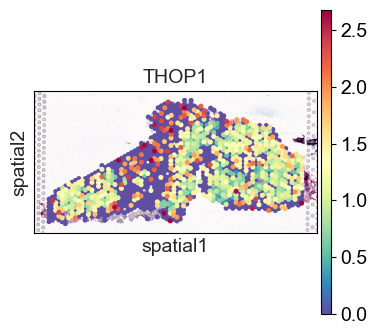

In [345]:
sc.pl.spatial(snv,color = 'chr19_2813592:G>A',spot_size = 80,vmax = 'p99.5',cmap = 'Spectral_r')
sc.pl.spatial(rawrna,color = 'THOP1',spot_size = 80,vmax = 'p99.5',cmap = 'Spectral_r')

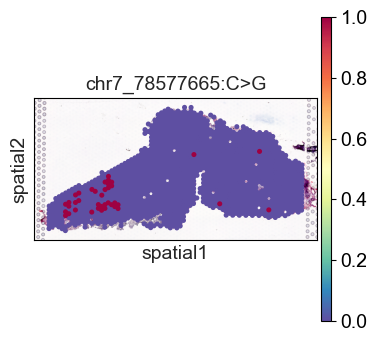

In [225]:
sc.pl.spatial(rawsnv,color = "chr7_78577665:C>G",spot_size = 80,cmap = 'Spectral_r')

In [223]:
rawsnv = sc.read_h5ad(f'../../SNV_process/norm/{sample}.norm_snv.h5ad')

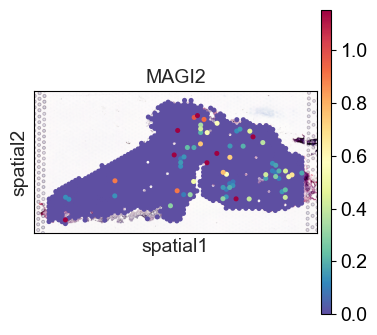

In [270]:
sc.pl.spatial(rawrna,color = 'MAGI2',spot_size = 80,vmax = 'p99.5',cmap = 'Spectral_r')

In [410]:
tumorsnv.obs['Pseudotime'] = monocle['Pseudotime']

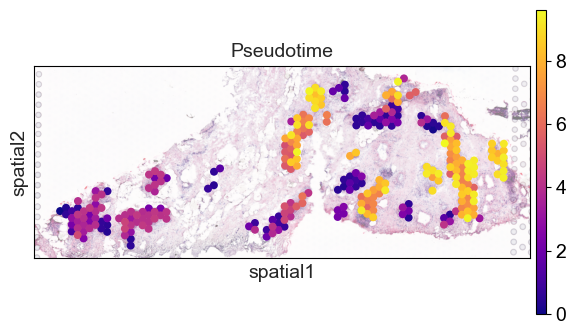

In [415]:
fig,ax = plt.subplots(figsize = (7,4))
sc.pl.spatial(tumorsnv,color = 'Pseudotime', basis = 'spatial',spot_size  = 70,ax = ax,cmap  ='plasma',alpha_img = 0.5,save='pseudo.pdf')